<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 100MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

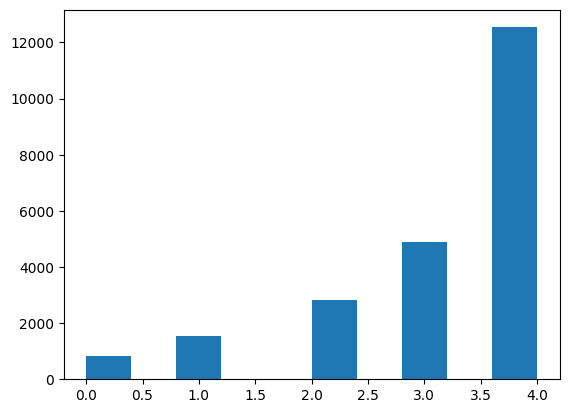

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
plt.hist(df_reviews['Rating']);

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
X=np.array(df_reviews['Review Text'])

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
X.shape

(22641,)

In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus
text_sequences = df_reviews['Review Text'].values
corpus = ' '.join(text_sequences)

In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [18]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 115


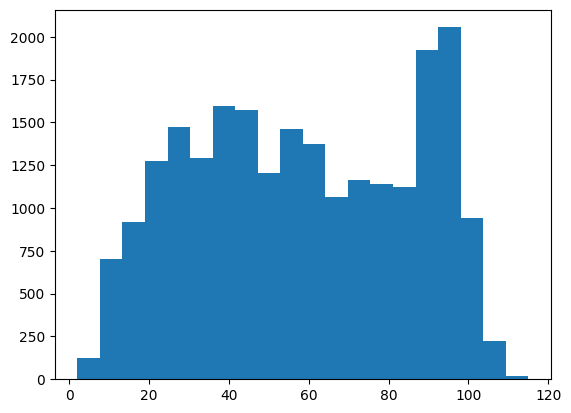

In [19]:
# y también explorar cómo es la distribución de tamaños de secuencias
plt.figure()
plt.hist(seqs_lenght,bins=20);

In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [21]:
# qué porcentaje de los datos se procesan completamente
(np.array(seqs_lenght)<maxlen).mean()

0.999955832339561

In [22]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = pd.get_dummies(df_reviews['Rating'])
print(y.shape)

(22641, 5)


In [24]:
y.head()

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [25]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [26]:
y_train.value_counts(normalize=True)

0  1  2  3  4
0  0  0  0  1    0.552838
         1  0    0.216210
      1  0  0    0.124614
   1  0  0  0    0.069898
1  0  0  0  0    0.036440
dtype: float64

In [27]:
y_train.value_counts()

0  1  2  3  4
0  0  0  0  1    10013
         1  0     3916
      1  0  0     2257
   1  0  0  0     1266
1  0  0  0  0      660
dtype: int64

In [28]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_train.shape[1] # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Definir el modelo con Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

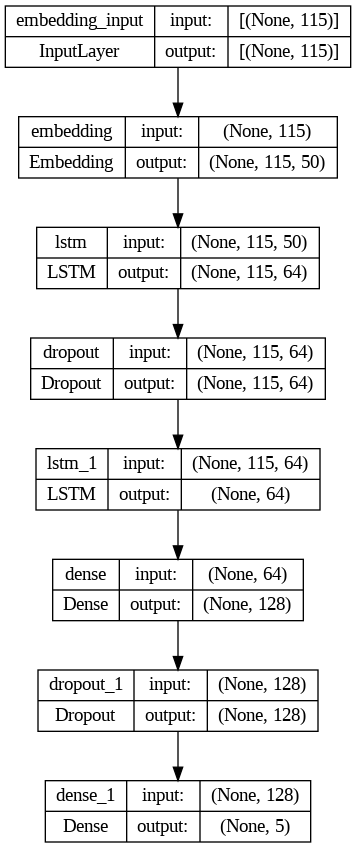

In [30]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##3 Entrenamiento del modelo asignando pesos a las muestras por desbalance



In [31]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

#calcula los pesos por clase
sample_weights = class_weight.compute_sample_weight(class_weight = "balanced", y=y_train )


In [33]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

seed_value = 42
tf.random.set_seed(seed_value)

# Compilar el modelo con F1-score como métrica
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    weighted_metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ]
)


# Entrenar el modelo
y_train_1 = tf.cast(y_train, dtype=tf.float32)
#history = model.fit(X_train, y_train_1, epochs=5, validation_split=0.2)
hist=model.fit(X_train, y_train_1, epochs=15, validation_split=0.2,sample_weight=sample_weights)

Epoch 1/15
453/453 [==============================] - 53s 111ms/step - loss: 0.5201 - accuracy: 0.4632 - precision_1: 0.3384 - recall_1: 0.9092 - val_loss: 0.5935 - val_accuracy: 0.3832 - val_precision_1: 0.3373 - val_recall_1: 0.8518
Epoch 2/15
453/453 [==============================] - 50s 111ms/step - loss: 0.4756 - accuracy: 0.5221 - precision_1: 0.3699 - recall_1: 0.9150 - val_loss: 0.6005 - val_accuracy: 0.4191 - val_precision_1: 0.3452 - val_recall_1: 0.8385
Epoch 3/15
453/453 [==============================] - 49s 108ms/step - loss: 0.4385 - accuracy: 0.5737 - precision_1: 0.3855 - recall_1: 0.9274 - val_loss: 0.6807 - val_accuracy: 0.3839 - val_precision_1: 0.3271 - val_recall_1: 0.8001
Epoch 4/15
453/453 [==============================] - 49s 107ms/step - loss: 0.4039 - accuracy: 0.6092 - precision_1: 0.3991 - recall_1: 0.9342 - val_loss: 0.7345 - val_accuracy: 0.3890 - val_precision_1: 0.3224 - val_recall_1: 0.7876
Epoch 5/15
453/453 [==============================] - 49s 10

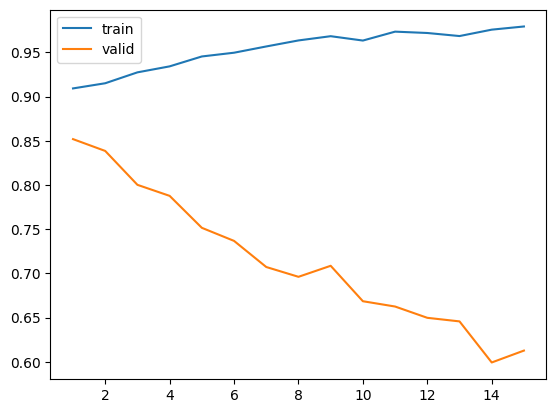

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['recall_1']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['recall_1'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_recall_1'], label='valid')
plt.show()

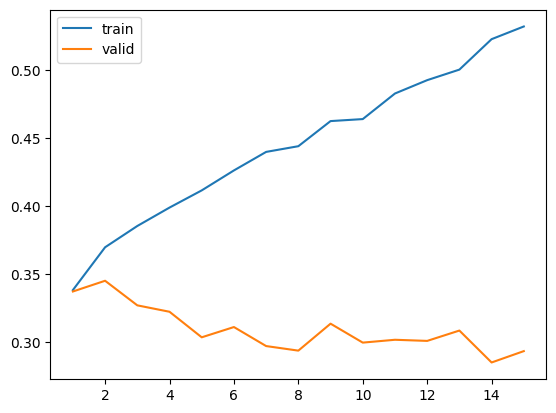

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['precision_1']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['precision_1'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_precision_1'], label='valid')
plt.show()